<a href="https://colab.research.google.com/github/shama-llama/crop-mapping/blob/main/src/cmap_rgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Crop Mapping with Deep Learning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [ ]:
import os
import io
import h5py
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

### Parameter Configuration

In [ ]:
# Dataset parameters
hdf5_path = "/content/drive/MyDrive/projects/crop-mapping-with-deep-learning/crop-mapping/dataset/dataset_ca_18.hdf5"
image_size = (65, 65)
image_height, image_width = image_size
# Use only the RGB sensor
sensors = ["RGB"]
crop_mapping = {
    "BARLEY": 0,
    "CANOLA": 1,
    "CORN": 2,
    "MIXEDWOOD": 3,
    "OAT": 4,
    "ORCHARD": 5,
    "PASTURE": 6,
    "POTATO": 7,
    "SOYBEAN": 8,
    "SPRING_WHEAT": 9,
}

# Training parameters
batch_size = 16
num_classes = 10
input_shape = (image_height, image_width, 3)
epochs = 50
patience = 5

# Set random seed
random.seed(42)
np.random.seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load and Verify Dataset

In [ ]:
# Function to decode an image stored as a variable-length uint8 array
def decode_image(uint8_array, sensor_type):
    if uint8_array.size == 0:
        return None

    image_bytes = uint8_array.tobytes()

    try:
        image = Image.open(io.BytesIO(image_bytes))
        image = image.convert("RGB")
        return image
    except Exception as e:
        print(f"Error decoding image:", e)
        return None

In [ ]:
# Generator for lazy loading records from HDF5 file
def load_records(hdf5_path):
    records = []
    with h5py.File(hdf5_path, "r") as hf:
        num_records = hf["POINT"].shape[0]
        for idx in range(num_records):
            record = {
                "DATE": hf["DATE"][idx],
                "POINT": hf["POINT"][idx],
                "REGION": hf["REGION"][idx],
                "LABEL": hf["LABEL"][idx],
            }
            for sensor in sensors:
                sensor_data = hf[sensor][idx]
                record[sensor] = decode_image(sensor_data, sensor)
            records.append(record)
    return records


# Load records with memory-efficient generator
records = list(load_records(hdf5_path))

# Verification
print(f"Total records loaded: {len(records)}")

Total records loaded: 18325


### Prepare Data Arrays

In [ ]:
def compute_sensor_stats(records, sensors):
    sensor_stats = {}
    for sensor in sensors:
        imgs = []
        for rec in records:
            # Get the sensor image from the record (decoded already)
            img = rec[sensor]
            if img is None:
                continue
            # Convert to numpy array and scale to [0,1]
            arr = np.array(img, dtype=np.float32) / 255.0
            imgs.append(arr)
        # Stack all images into a tensor of shape (N, H, W, C)
        all_imgs = np.stack(imgs, axis=0)
        # Compute mean and std over N, H, and W (keeping channel dimension)
        mean = np.mean(all_imgs, axis=(0, 1, 2))
        std = np.std(all_imgs, axis=(0, 1, 2))
        sensor_stats[sensor] = (mean, std)
    return sensor_stats

sensor_stats = compute_sensor_stats(records, sensors)

In [ ]:
# Group records by (POINT, REGION)
grouped = defaultdict(list)
for rec in records:
    key = (rec['POINT'], rec['REGION'])
    grouped[key].append(rec)

# Build sequences: sort by DATE and keep only groups with at least 3 records.
sequences = []
labels = []
for key, recs in grouped.items():
    recs_sorted = sorted(recs, key=lambda r: r['DATE'])
    if len(recs_sorted) >= 3:
        seq_images = []
        for r in recs_sorted:
            # Assume r[sensor] is a PIL Image from which we obtain a numpy array.
            rgb = np.array(r['RGB'], dtype=np.float32) / 255.0
            # For RGB, sensor_stats['RGB'] returns (mean_rgb, std_rgb) each of shape (3,)
            mean_rgb, std_rgb = sensor_stats['RGB']
            rgb_norm = (rgb - mean_rgb) / std_rgb

            seq_images.append(rgb_norm)

        sequences.append(np.array(seq_images))
        labels.append(recs_sorted[0]['LABEL'])

print(f"Total sequences with at least 3 time steps: {len(sequences)}")

Total sequences with at least 3 time steps: 4240


### Train/Validation/Test Split

In [ ]:
seq_train, seq_temp, label_train, label_temp = train_test_split(
    sequences, labels, test_size=0.20, stratify=labels, random_state=42
)
seq_val, seq_test, label_val, label_test = train_test_split(
    seq_temp, label_temp, test_size=0.5, stratify=label_temp, random_state=42
)
print("Train sequences:", len(seq_train))
print("Validation sequences:", len(seq_val))
print("Test sequences:", len(seq_test))

Train sequences: 3392
Validation sequences: 424
Test sequences: 424


### Create Dataset

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels, augment=False):
        self.sequences = sequences
        self.labels = labels
        self.augment = augment
        # Base transform: converts numpy array (H,W,C) to tensor (C,H,W)
        self.base_transform = transforms.Compose([
            transforms.Lambda(lambda x: torch.from_numpy(x).permute(2, 0, 1).float()),
        ])
        # Spatial augmentations only
        self.augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.3),
            transforms.RandomRotation(degrees=(-25, 25)),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        ])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]   # seq is an array of fused images (each a numpy array)
        label = self.labels[idx]
        processed_seq = []
        for img in seq:
            img_tensor = self.base_transform(img)
            if self.augment:
                img_tensor = self.augment_transform(img_tensor)
            processed_seq.append(img_tensor)
        seq_length = len(processed_seq)
        # Do not pad here; return the list and its length
        return processed_seq, label, seq_length

def collate_fn(batch):
    # Each element in batch is a tuple: (list_of_tensors, label, seq_length)
    sequences, labels, lengths = zip(*batch)
    # Convert list of tensors for each sample into a single tensor of shape (seq_len, C, H, W)
    sequences = [torch.stack(seq) for seq in sequences]
    # Pad sequences (batch_first=True gives shape (batch, max_seq_len, C, H, W))
    padded_seqs = pad_sequence(sequences, batch_first=True)
    lengths = torch.tensor(lengths)
    # Sort by descending lengths (required for pack_padded_sequence)
    lengths, sort_idx = lengths.sort(descending=True)
    padded_seqs = padded_seqs[sort_idx]
    labels = torch.tensor(labels)[sort_idx]
    # Pack the padded sequence
    packed_seqs = pack_padded_sequence(padded_seqs, lengths.cpu(), batch_first=True)
    return packed_seqs, labels, lengths

train_dataset = SequenceDataset(seq_train, label_train, augment=True)
val_dataset = SequenceDataset(seq_val, label_val, augment=False)
test_dataset = SequenceDataset(seq_test, label_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn)

### Model Definition

In [ ]:
# Define a basic ConvLSTM cell
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        padding = kernel_size // 2
        self.hidden_channels = hidden_channels
        self.conv = nn.Conv2d(input_channels + hidden_channels, 4 * hidden_channels,
                              kernel_size, padding=padding)

    def forward(self, input_tensor, h_cur, c_cur):
        # Concatenate along channel dimension
        combined = torch.cat([input_tensor, h_cur], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

# Define the overall ConvLSTM network
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_classes):
        super(ConvLSTM, self).__init__()
        self.hidden_channels = hidden_channels
        self.cell = ConvLSTMCell(input_channels, hidden_channels, kernel_size)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(hidden_channels, num_classes)

    def forward(self, packed_seq):
        # Unpack the PackedSequence into padded_seq and obtain lengths
        padded_seq, lengths = torch.nn.utils.rnn.pad_packed_sequence(packed_seq, batch_first=True)
        # padded_seq shape: (batch, max_seq_len, channels, H, W)
        batch_size, max_seq_len, channels, height, width = padded_seq.size()
        device = padded_seq.device

        # Initialize hidden and cell states
        h = torch.zeros(batch_size, self.hidden_channels, height, width, device=device)
        c = torch.zeros(batch_size, self.hidden_channels, height, width, device=device)

        # Process each time step for sequences that have valid data
        for t in range(max_seq_len):
            # Find which sequences have a time step t
            active_idx = (lengths > t).nonzero(as_tuple=True)[0]
            if active_idx.numel() == 0:
                break
            # Process only active sequences
            input_t = padded_seq[active_idx, t]  # shape: (active, channels, H, W)
            h_active = h[active_idx]
            c_active = c[active_idx]
            h_new, c_new = self.cell(input_t, h_active, c_active)
            h[active_idx] = h_new
            c[active_idx] = c_new

        pooled = self.pool(h)  # shape: (batch, hidden_channels, 1, 1)
        pooled = pooled.view(batch_size, -1)
        output = self.fc(pooled)
        return output

In [ ]:
# Calculate the frequency of each class in label_train
classes = np.unique(label_train)
class_weights = compute_class_weight('balanced', classes=classes, y=label_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Initialize Model, Loss, and Optimizer
model = ConvLSTM(input_channels=3, hidden_channels=32, kernel_size=3, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Model Training

In [12]:
history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_correct = 0
    for seqs, labels, lengths in train_loader:
        seqs = seqs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += torch.sum(preds == labels).item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_correct / len(train_loader.dataset)
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for seqs, labels, lengths in val_loader:
            seqs = seqs.to(device)
            labels = labels.to(device)

            outputs = model(seqs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels).item()

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / len(val_loader.dataset)
    history['val_loss'].append(val_epoch_loss)
    history['val_accuracy'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}\n")

    # Early stopping check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1/50
Train Loss: 1.9442, Acc: 0.3558
Val Loss: 1.6237, Acc: 0.4976

Epoch 2/50
Train Loss: 1.5393, Acc: 0.5433
Val Loss: 1.3842, Acc: 0.6085

Epoch 3/50
Train Loss: 1.3527, Acc: 0.6135
Val Loss: 1.2218, Acc: 0.6557

Epoch 4/50
Train Loss: 1.2529, Acc: 0.6427
Val Loss: 1.1774, Acc: 0.6675

Epoch 5/50
Train Loss: 1.1768, Acc: 0.6657
Val Loss: 1.0714, Acc: 0.6887

Epoch 6/50
Train Loss: 1.1358, Acc: 0.6725
Val Loss: 1.0804, Acc: 0.7075

Epoch 7/50
Train Loss: 1.0875, Acc: 0.6819
Val Loss: 0.9974, Acc: 0.7005

Epoch 8/50
Train Loss: 1.0503, Acc: 0.6922
Val Loss: 0.9816, Acc: 0.7099

Epoch 9/50
Train Loss: 1.0170, Acc: 0.7037
Val Loss: 0.9457, Acc: 0.7382

Epoch 10/50
Train Loss: 1.0046, Acc: 0.7105
Val Loss: 0.9521, Acc: 0.7241

Epoch 11/50
Train Loss: 0.9708, Acc: 0.7108
Val Loss: 0.9526, Acc: 0.7429

Epoch 12/50
Train Loss: 0.9563, Acc: 0.7196
Val Loss: 0.9238, Acc: 0.7382

Epoch 13/50
Train Loss: 0.9393, Acc: 0.7261
Val Loss: 0.8916, Acc: 0.7406

Epoch 14/50
Train Loss: 0.9388, Ac

### Model Evaluation

In [13]:
model.eval()
test_loss = 0.0
correct = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for packed_seq, label, length in test_loader:
        # Move the underlying data to device:
        packed_seq = torch.nn.utils.rnn.PackedSequence(
            packed_seq.data.to(device),
            packed_seq.batch_sizes,
            packed_seq.sorted_indices,
            packed_seq.unsorted_indices
        )
        label = label.to(device)

        outputs = model(packed_seq)  # Model's forward unpacks internally
        loss = criterion(outputs, label)
        test_loss += loss.item() * label.size(0)  # use batch size from labels
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == label).item()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

test_loss /= len(test_loader.dataset)
accuracy = correct / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Test Loss: 0.9152, Test Accuracy: 0.7335


In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(crop_mapping.keys()),
            yticklabels=list(crop_mapping.keys()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# Compute and print classwise metrics
report = classification_report(all_labels, all_preds, target_names=list(crop_mapping.keys()))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

      BARLEY       0.55      0.46      0.50        24
      CANOLA       0.97      0.86      0.91        80
        CORN       0.61      0.80      0.70        61
   MIXEDWOOD       0.86      1.00      0.93        31
         OAT       0.30      0.21      0.25        14
     ORCHARD       0.90      1.00      0.95        45
     PASTURE       0.63      0.71      0.67        59
      POTATO       0.56      0.56      0.56        18
     SOYBEAN       0.55      0.26      0.35        42
SPRING_WHEAT       0.77      0.80      0.78        50

    accuracy                           0.73       424
   macro avg       0.67      0.67      0.66       424
weighted avg       0.73      0.73      0.72       424



### Plot Training Curves

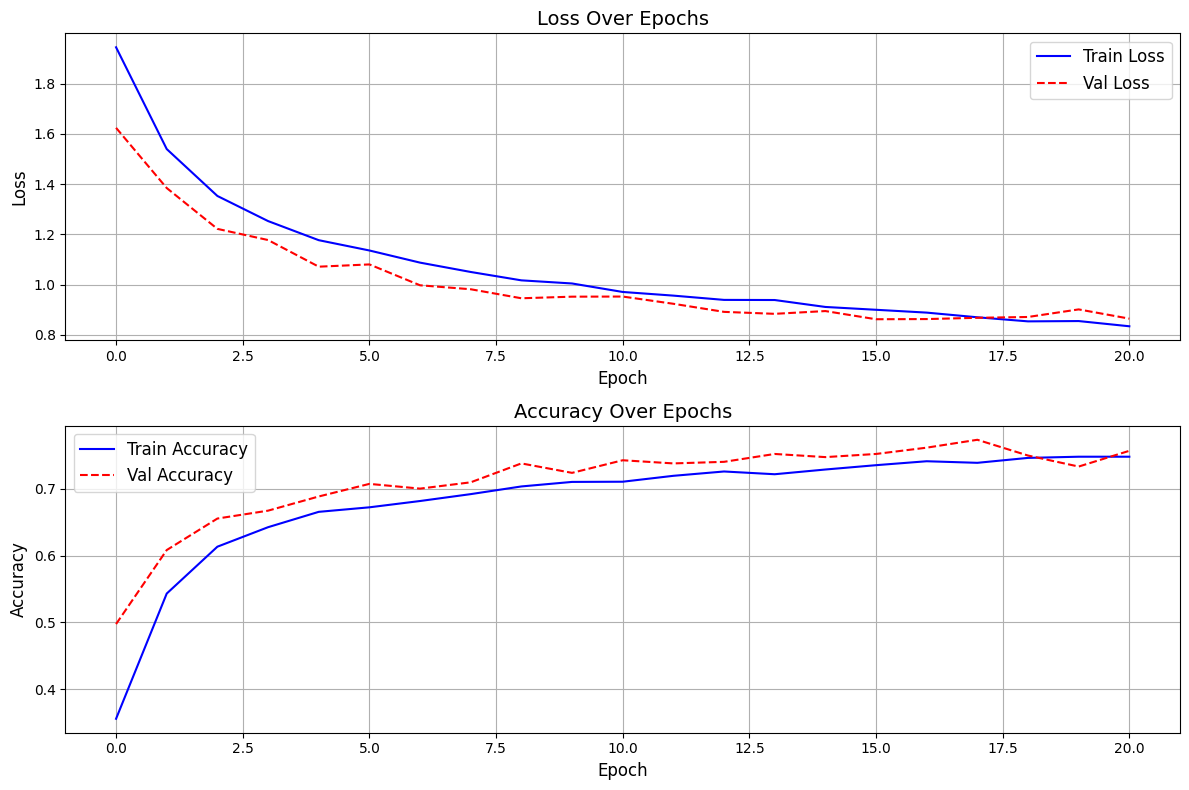

In [16]:
plt.figure(figsize=(12, 8))

# Loss Plot
plt.subplot(2, 1, 1)
plt.plot(history['loss'], label='Train Loss', color='blue', linestyle='-')
plt.plot(history['val_loss'], label='Val Loss', color='red', linestyle='--')
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Accuracy Plot
plt.subplot(2, 1, 2)
plt.plot(history['accuracy'], label='Train Accuracy', color='blue', linestyle='-')
plt.plot(history['val_accuracy'], label='Val Accuracy', color='red', linestyle='--')
plt.title('Accuracy Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()